<a href="https://colab.research.google.com/github/filipoky/my_hw_ds_projects/blob/main/Hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# 1. імпорти + завантаження CSV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

np.random.seed(42)

# ---------- Завантаження CSV з Google Drive ----------
# Посилання: https://drive.google.com/file/d/19mHtlTWkNLZ5veLSgs7QxPCI-9SDvDJX/view?usp=drive_link
file_id = "19mHtlTWkNLZ5veLSgs7QxPCI-9SDvDJX"   # ID з посиланняа
url = f"https://drive.google.com/uc?export=download&id={file_id}"

# Читаємо CSV напряму
df = pd.read_csv(url)

print("Розмір датасету:", df.shape)
print("Перші 5 рядків:")
display(df.head())
print("\nНазви колонок:")
print(df.columns.tolist())


Розмір датасету: (545, 13)
Перші 5 рядків:


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished



Назви колонок:
['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']


In [11]:
# 2: знайдемо потрібні колонки автоматично (якщо назви відрізняються)
def pick_first_present(candidates, columns):
    cols_lower = {c.lower(): c for c in columns}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    return None

cols = df.columns

price_candidates = ["price", "saleprice", "price_usd", "cost"]
area_candidates  = ["area", "sqft", "square_feet", "size", "total_sqft"]
bath_candidates  = ["bath", "bathroom", "bathrooms", "baths"]
bed_candidates   = ["bed", "beds", "bedroom", "bedrooms"]

price_col = pick_first_present(price_candidates, cols)
area_col  = pick_first_present(area_candidates, cols)
bath_col  = pick_first_present(bath_candidates, cols)
bed_col   = pick_first_present(bed_candidates, cols)

print("Виявлені колонки:")
print(" price ->", price_col)
print(" area  ->", area_col)
print(" bath  ->", bath_col)
print(" bed   ->", bed_col)

# Можна вказати вручну
# price_col = 'price'
# area_col = 'area'
# bath_col = 'bathrooms'
# bed_col = 'bedrooms'

# Перевірка
required = {"price":price_col, "area":area_col, "bath":bath_col, "bed":bed_col}
missing  = [k for k,v in required.items() if v is None]
if missing:
    raise ValueError(f"Не знайдені колонки для: {missing}. Подивись df.columns і скорегуй кандидатів або підстав конкретні імена.")

# Відберемо ці колонки та очистимо пропуски
use_cols = [price_col, area_col, bath_col, bed_col]
df_clean = df[use_cols].copy()

# Перетворимо в числові (на випадок, якщо там рядки)
for c in use_cols:
    df_clean[c] = pd.to_numeric(df_clean[c], errors='coerce')

# Видалимо рядки з пропусками
df_clean = df_clean.dropna().reset_index(drop=True)

print("Розмір після очистки:", df_clean.shape)
display(df_clean.head())


Виявлені колонки:
 price -> price
 area  -> area
 bath  -> bathrooms
 bed   -> bedrooms
Розмір після очистки: (545, 4)


,price,area,bathrooms,bedrooms
0,13300000,7420,2,4
1,12250000,8960,4,4
2,12250000,9960,2,3
3,12215000,7500,2,4
4,11410000,7420,1,4


In [12]:
# 3: підготовка X, y, split, масштабування
features = [area_col, bath_col, bed_col]
target = price_col

X = df_clean[features].values.astype(float)
y = df_clean[target].values.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

print("Train shape:", X_train_s.shape, "Test shape:", X_test_s.shape)


Train shape: (436, 3) Test shape: (109, 3)


In [13]:
# 4: векторні функції

def add_bias(X):
    """Додаємо стовпець одиниць для intercept (w0)"""
    return np.hstack([np.ones((X.shape[0], 1)), X])

def hypothesis(Xb, w):
    """Векторна гіпотеза h = Xb @ w"""
    return Xb.dot(w)

def mse_cost(Xb, y, w):
    """J(w) = 1/(2m) * sum((h-y)^2)"""
    m = len(y)
    errs = Xb.dot(w) - y
    return (errs @ errs) / (2 * m)

def gradient_step(Xb, y, w, alpha):
    """Один крок градієнтного спуску (векторно)"""
    m = len(y)
    grad = (Xb.T @ (Xb.dot(w) - y)) / m
    return w - alpha * grad

# Невелика утиліта для RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


Навчені ваги (GD): [4706527.38532106  760642.88074098  678224.07261083  269048.26622011]
Фінальний train J(w) (1/(2m) sum sq): 780367992695.8802
GD – RMSE: 1658324.6001, R²: 0.4559


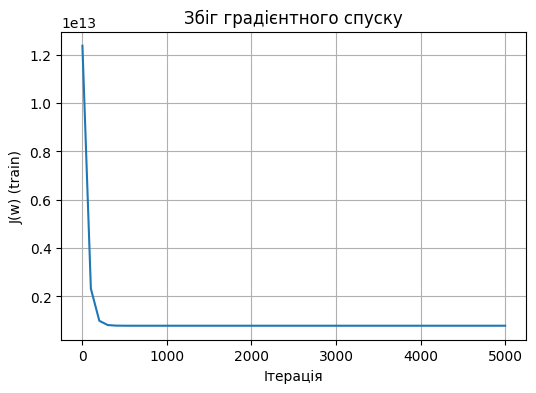

In [14]:
# 5: навчаємо GD
Xb_train = add_bias(X_train_s)
Xb_test  = add_bias(X_test_s)

n_features = Xb_train.shape[1]
w = np.zeros(n_features)    # початкові ваги (всі нулі)

alpha = 0.01   # learning rate — спробував поміняти ра такі (0.01, 0.05, 0.1)
n_iters = 5000  # ітерацій — за потреби збільшував

history = []
for it in range(n_iters):
    w = gradient_step(Xb_train, y_train, w, alpha)
    if (it+1) % 100 == 0 or it == 0:
        history.append(mse_cost(Xb_train, y_train, w))

print("Навчені ваги (GD):", w)
print("Фінальний train J(w) (1/(2m) sum sq):", mse_cost(Xb_train, y_train, w))

# Метрики на тесті (використовуємо rmse)
y_pred_gd = hypothesis(Xb_test, w)
print(f"GD – RMSE: {rmse(y_test, y_pred_gd):.4f}, R²: {r2_score(y_test, y_pred_gd):.4f}")

# Графік збіжності (опціонально)
plt.figure(figsize=(6,4))
plt.plot(np.arange(len(history))*100 + 1, history)
plt.xlabel("Ітерація")
plt.ylabel("J(w) (train)")
plt.title("Збіг градієнтного спуску")
plt.grid(True)
plt.show()


In [15]:
# 6: normal equation (на тих же масштабованих Xb_train)
w_ne = np.linalg.pinv(Xb_train) @ y_train
y_pred_ne = Xb_test @ w_ne

print("Ваги (Normal Equation):", w_ne)
print(f"Normal Eq – RMSE: {rmse(y_test, y_pred_ne):.4f}, R²: {r2_score(y_test, y_pred_ne):.4f}")


Ваги (Normal Equation): [4706527.3853211   760642.88074097  678224.07261084  269048.2662201 ]
Normal Eq – RMSE: 1658324.6001, R²: 0.4559


In [16]:
# 7: sklearn для порівняння
pipe = None
# Ми вже масштабували X окремо, тому просто навчаємо LinearRegression на X_train_s
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train_s, y_train)

# Збираємо ваги в той же формат (intercept + coeffs)
w_sklearn = np.hstack([lr.intercept_, lr.coef_])
y_pred_sk = lr.predict(X_test_s)

print("Ваги (sklearn):", w_sklearn)
print(f"sklearn – RMSE: {rmse(y_test, y_pred_sk):.4f}, R²: {r2_score(y_test, y_pred_sk):.4f}")

# Порівняння норм (відстаней між векторами ваг)
def l2norm(a,b): return np.linalg.norm(a-b)

print("||w_GD - w_NE|| =", l2norm(w, w_ne))
print("||w_GD - w_sklearn|| =", l2norm(w, w_sklearn))
print("||w_NE - w_sklearn|| =", l2norm(w_ne, w_sklearn))


Ваги (sklearn): [4706527.3853211   760642.88074097  678224.07261084  269048.2662201 ]
sklearn – RMSE: 1658324.6001, R²: 0.4559
||w_GD - w_NE|| = 4.802086164560748e-08
||w_GD - w_sklearn|| = 4.881787372817857e-08
||w_NE - w_sklearn|| = 9.670182902969041e-10


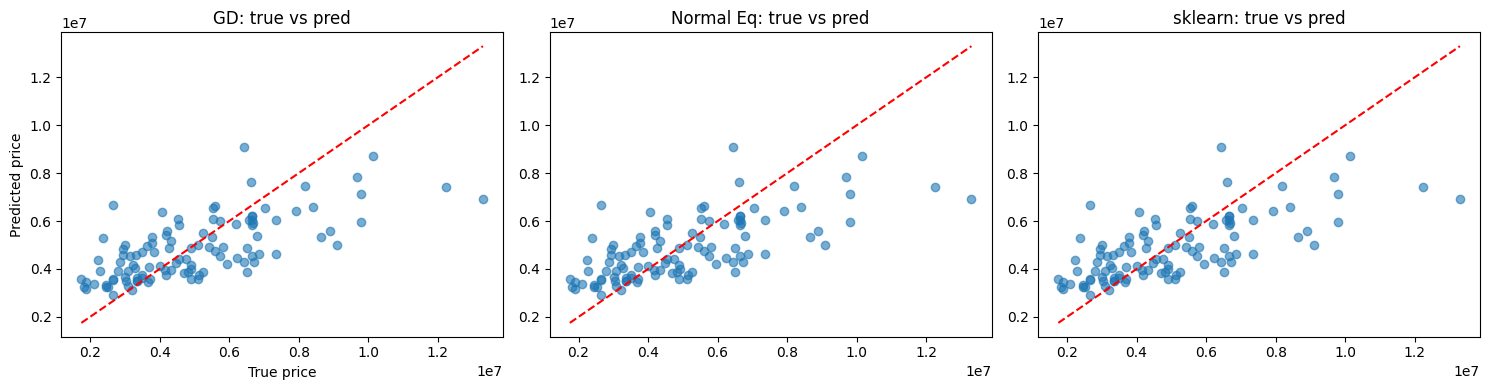

In [17]:
# 8: scatter true vs pred (трьома підходами)
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.scatter(y_test, y_pred_gd, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('GD: true vs pred')
plt.xlabel('True price')
plt.ylabel('Predicted price')

plt.subplot(1,3,2)
plt.scatter(y_test, y_pred_ne, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Normal Eq: true vs pred')

plt.subplot(1,3,3)
plt.scatter(y_test, y_pred_sk, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('sklearn: true vs pred')

plt.tight_layout()
plt.show()
